# Neural Network, Image Recognition & Object Orientation 
## Michael Godwin Ehizojie
### Sudent ID: 1603dc278b81f000

In [2]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-train-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-test-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv
/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv
/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv
/kaggle/input/planets-dataset/planet/planet/sample_submission.csv
/kaggle/input/planets-dataset/planet/planet/train_classes.csv
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_39140.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_4849.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_18979.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_30624.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_7

In [9]:
# importing libraries
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from matplotlib.image import imread
import cv2 
from tensorflow import keras 
from tqdm import tqdm
from sklearn.model_selection import train_test_split 
import keras as k
from keras import optimizers
from keras.models import Sequential , Model
from keras.layers import Input , Dense , Dropout , Flatten
from keras.layers import Conv2D,MaxPooling2D , BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint 
from keras.preprocessing.image import ImageDataGenerator 
from keras import backend as K
from sklearn.metrics import fbeta_score

In [4]:
train_v2 = pd.read_csv("/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv")
train_v2.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [5]:
samp_submission = pd.read_csv("/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv")
samp_submission.head()

image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water

In [6]:
samp_submission.shape

(61191, 2)

In [7]:
# loading images
train_path = "/kaggle/input/planet-understanding-the-amazon-from-space/train-jpg"
test_path = "/kaggle/input/planet-understanding-the-amazon-from-space/test-jpg"
test_additional = "/kaggle/input/planet-understanding-the-amazon-from-space/test-jpg-additional"

- Viewing the first **four** images using matplotlib

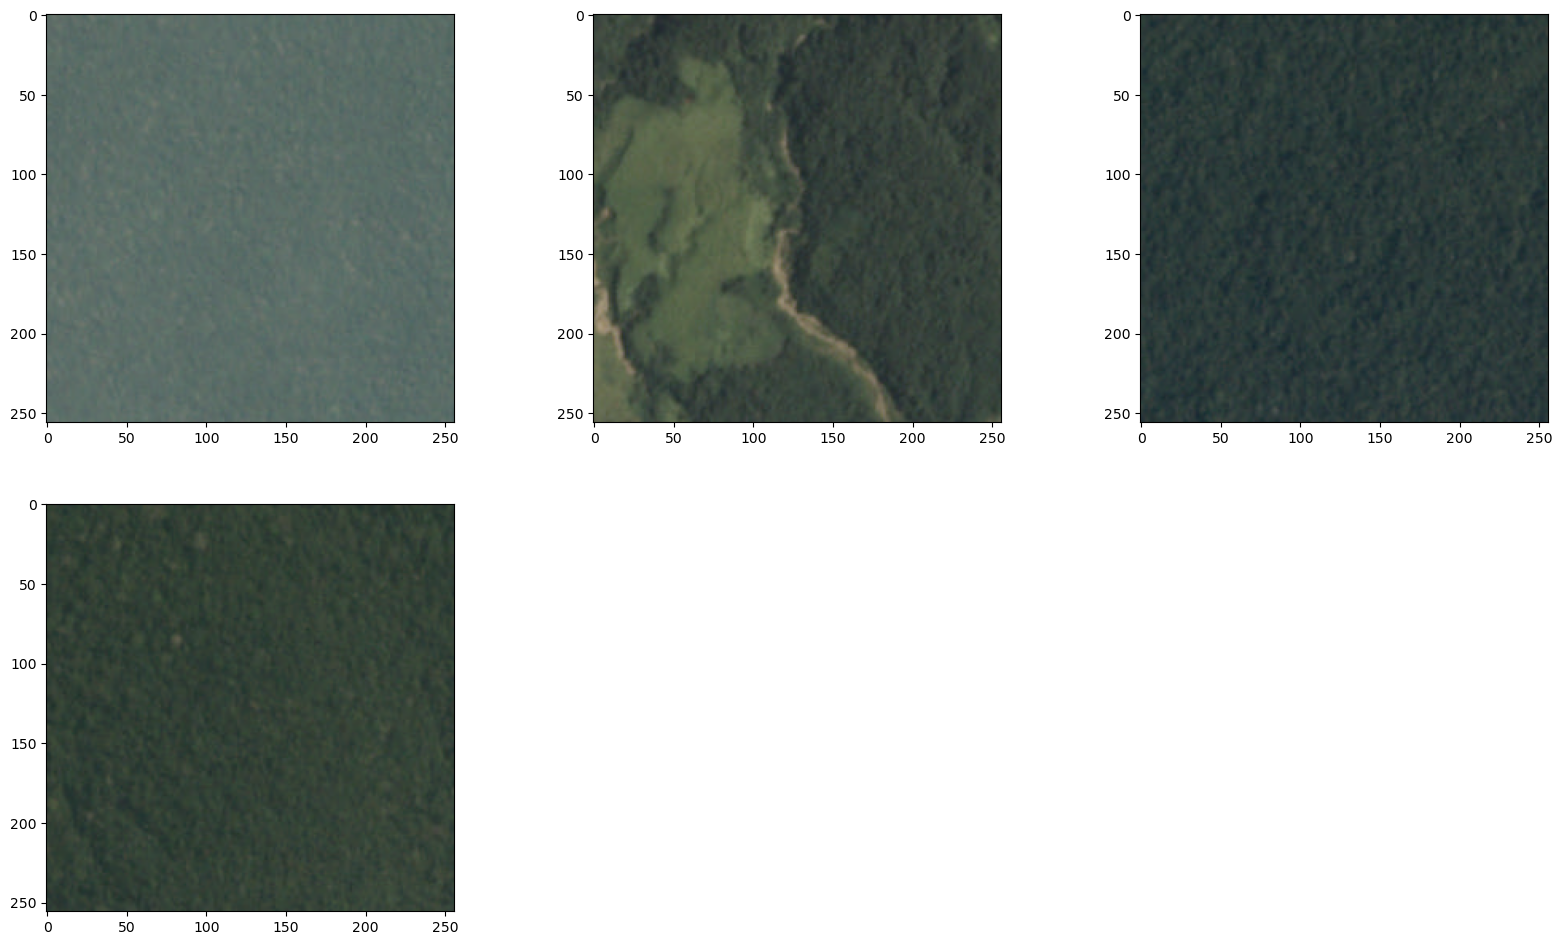

In [10]:
plt.figure(figsize=(20,18))
folder = '../input/planets-dataset/planet/planet/train-jpg/' # specifying the location of the dataset

# a for loop to plot the first 4 images
for i in range(4):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'train_' + str(i) + '.jpg' # defining the filename
    image = imread(filename) # loading the image pixels
    pyplot.imshow(image) # plots the raw pixel data
pyplot.show() # displays the images

- Reading the **training images**
- The for loop **appends** the training images and labels in the empty list

In [13]:
# an empty list of training images and labels
training_images = []
training_labels = []

labels = train_v2['tags'].str.get_dummies(sep=' ').columns

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# appends training images and labels in the empty list
for f, tags in tqdm(train_v2.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    training_images.append(cv2.resize(img, (32, 32)))
    training_labels.append(targets)

#scale pixel values
training_images = np.array(training_images, np.float16) / 255.
training_labels = np.array(training_labels, np.uint8)

100%|██████████| 40479/40479 [01:41<00:00, 400.32it/s]


- Printing the shape of  thetraining images and the training labels

In [14]:
# the print code which caused error in previous cell rerun succesfully
print(f"training data: {training_images.shape}, {training_labels.shape}")

training data: (40479, 32, 32, 3), (40479, 17)


- **Inspecting** the training classes

In [15]:
# inspecting the training classes
train_v2.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

- Getting the number of **unique** classes in the training set
- **449** unique classes

In [16]:
train_v2['tags'].nunique()

449

- **Merging** the test images and the additional test images

In [17]:
# empty list of test images
testing_images = []

# defining path to test images
test_jpg = '../input/planets-dataset/planet/planet/test-jpg' 
test_image_names = os.listdir(test_jpg)

n_test = len(test_image_names)
test_class = samp_submission.iloc[:n_test, :]
add_class = samp_submission.iloc[n_test:, :]

# defining path to additional test images
test_jpg_add = '../input/planets-dataset/test-jpg-additional/test-jpg-additional'
test_add_image_names = os.listdir(test_jpg_add)

- **Reading** the test images
- Includes the test images and the additional test images

In [18]:
for f, tags in tqdm(test_class.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    testing_images.append(cv2.resize(img, (32, 32)))
    
for f, tags in tqdm(add_class.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    testing_images.append(cv2.resize(img, (32, 32)))
    
testing_images = np.array(testing_images, np.float16) / 255.

100%|██████████| 20522/20522 [02:41<00:00, 126.78it/s]


- **Splitting** the data into training and validation sets
- Printing out the shapes of the split datasets

In [19]:
x_train = training_images[0:35000]
x_val = training_images[35000:]
y_train = training_labels[0:35000]
y_val = training_labels[35000:]


print(f"x_train: {x_train.shape}")
print(f"x_val: {x_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

x_train: (35000, 32, 32, 3)
x_val: (5479, 32, 32, 3)
y_train: (35000, 17)
y_val: (5479, 17)


- **Optimizing** to train our deep neural network
- Building a **sequential feed foward neural network**

In [20]:
# instantiating the sequential feed forward NN
model = Sequential()

# building the input and hidden layers
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

- **Compliling** the model

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


- **Fitting** our model
- Tuning the batch sizes had an effect on the fbeta score
- **Batch size** of 32 chosen (has to be a multiple of 2)

In [28]:
# fit the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=3, verbose=1)

Epoch 1/3
1094/1094 [==============================] - 81s 74ms/step - loss: 0.1464 - accuracy: 0.0964 - val_loss: 0.1435 - val_accuracy: 0.0745
Epoch 2/3
1094/1094 [==============================] - 81s 74ms/step - loss: 0.1435 - accuracy: 0.1016 - val_loss: 0.1421 - val_accuracy: 0.0721
Epoch 3/3
1094/1094 [==============================] - 80s 74ms/step - loss: 0.1424 - accuracy: 0.0967 - val_loss: 0.1406 - val_accuracy: 0.0597


- **Fbeta score**

In [29]:
p_val = model.predict(x_val, batch_size=4)
p_train = model.predict(training_images, batch_size=4,verbose=3)
p_test = model.predict(testing_images, batch_size=4,verbose=3)
print(fbeta_score(y_val, np.array(p_val) > 0.2, beta=2, average='samples'))

1370/1370 [==============================] - 6s 5ms/step
0.8668396077749959


- **Saving** ground truth and predicted probability for the training dataset
- **Computing** the best thresholds

- **Converting our submission to a .csv file**
- The **for loop** appends the test labels in the empty list created

In [30]:
# test values
values_test = (p_test > .222222)*1.0        
values_test = np.array(values_test, np.uint8)

# creating an empty list of test labels
test_labels = []

for row in range(values_test.shape[0]):
    test_labels.append(' '.join(labels[values_test[row,:]==1]))
    
submission = samp_submission.copy()
submission.drop('tags', axis = 1)
submission['tags'] = test_labels
submission.to_csv('godwin_submission_2.csv', index = False)